# Modelos Custom

In [32]:
import torch
import scipy.io as sio
import matplotlib.pyplot as plt
import random
import numpy as np

In [33]:
# Cargar el archivo MAT
emnist_digits = sio.loadmat('emnist-digits.mat')

In [34]:
# cargamos las caracteristicas de emnist de entrenamiento
X_train = emnist_digits["dataset"]["train"][0][0]["images"][0][0].astype('float64') 
print("Shape X_train: ", X_train.shape)
# cargamos las etiquetas de emnist de entrenamiento
y_train = emnist_digits["dataset"]["train"][0][0]["labels"][0][0].ravel().astype('int64')
print("Shape y_train: ", y_train.shape)

# cargamos las caracteristicas de emnist de prueba
X_test = emnist_digits["dataset"]["test"][0][0]["images"][0][0].astype('float64') 
print("Shape X_test: ", X_test.shape)
# cargamos las etiquetas de emnist de prueba
y_test = emnist_digits["dataset"]["test"][0][0]["labels"][0][0].ravel().astype('int64')
print("Shape y_test: ", y_test.shape)

Shape X_train:  (240000, 784)
Shape y_train:  (240000,)
Shape X_test:  (40000, 784)
Shape y_test:  (40000,)


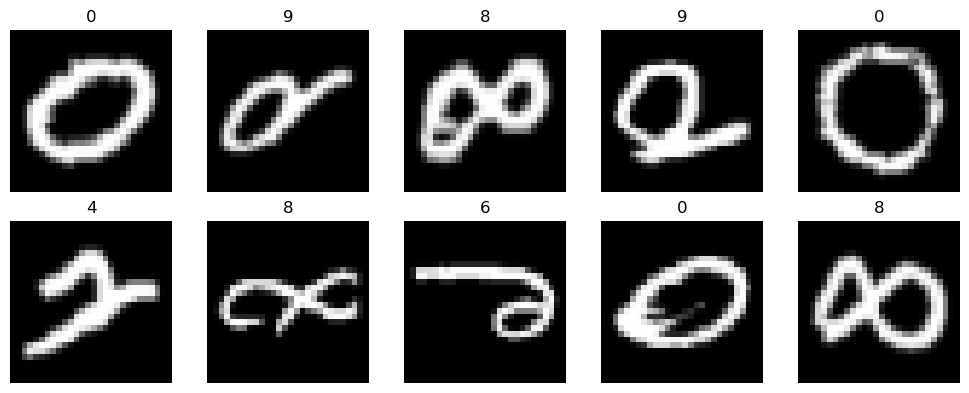

In [25]:
r, c = 2, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_train)-1)
        img = X_train[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y_train[ix])
plt.tight_layout()
plt.show()

In [35]:
# normalizamos las caracteristicas
X_train = X_train / 255.0
X_test = X_test / 255.0

In [36]:
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()

In [28]:
# creamos una clase que hereda de `torch.nn.Module`

class ModeloPersonalizado(torch.nn.Module):

    # constructor
    def __init__(self, D_in, H, D_out):

        # llamamos al constructor de la clase madre
        super(ModeloPersonalizado, self).__init__()

        # definimos nuestras capas
        self.fc1 = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(H, D_out)

    # lógica para calcular las salidas de la red
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [37]:
model = ModeloPersonalizado(784, 100, 10)
# Codigo para saber si el modelo esta votando los datos en las cantidades correctas
x_prueba = torch.randn(64, 784)
print(x_prueba)
outputs = model(x_prueba)
outputs.shape

tensor([[ 0.5136, -0.1533,  2.2099,  ...,  0.0576, -1.2495,  0.8120],
        [-0.1367,  0.4378, -0.0902,  ..., -0.8877, -0.7372, -1.7833],
        [-0.0447,  0.5446, -0.1944,  ...,  1.3016,  0.9859, -0.5581],
        ...,
        [-0.4401,  0.5034, -0.7784,  ..., -1.4375,  1.8752, -1.3854],
        [-0.2515,  2.5962, -0.6532,  ...,  0.7402,  0.6284,  1.0935],
        [ 0.7339,  0.3080, -0.8970,  ..., -1.4997, -0.6626, -0.2055]])


torch.Size([64, 10])

In [43]:
from sklearn.metrics import accuracy_score

def evaluate(x):
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1) # type: ignore

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True) # type: ignore

def calculate_accuracy(model, X_t):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        y_pred = model(X_t)
        _, predicted = torch.max(y_pred.data, 1)
        total = X_t.size(0)
        correct = predicted.sum().item()

    accuracy = correct / total
    return accuracy

In [44]:
model.to("cuda")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.7)

epochs = 100
log_each = 10
accuracy = 0
l = []
accuracy_values = []
model.train()
for e in range(1, epochs+1):

    # forward
    y_pred = model(X_t)

    # loss
    loss = criterion(y_pred, Y_t)
    l.append(loss.item())

    # ponemos a cero los gradientes
    optimizer.zero_grad()

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    # update de los pesos
    optimizer.step()

    if not e % log_each:
        accuracy = calculate_accuracy(model, X_t)
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} accuracy {accuracy:.4f}")
    
    l.append(loss.item())
    accuracy_values.append(accuracy)

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

Epoch 10/100 loss 0.21736 accuracy 4.5511
Epoch 20/100 loss 0.20882 accuracy 4.5432
Epoch 30/100 loss 0.19970 accuracy 4.5311
Epoch 40/100 loss 0.19262 accuracy 4.5222
Epoch 50/100 loss 0.18684 accuracy 4.5165
Epoch 60/100 loss 0.18173 accuracy 4.5133
Epoch 70/100 loss 0.17704 accuracy 4.5121
Epoch 80/100 loss 0.17271 accuracy 4.5104
Epoch 90/100 loss 0.16867 accuracy 4.5089
Epoch 100/100 loss 0.16489 accuracy 4.5078


0.952275

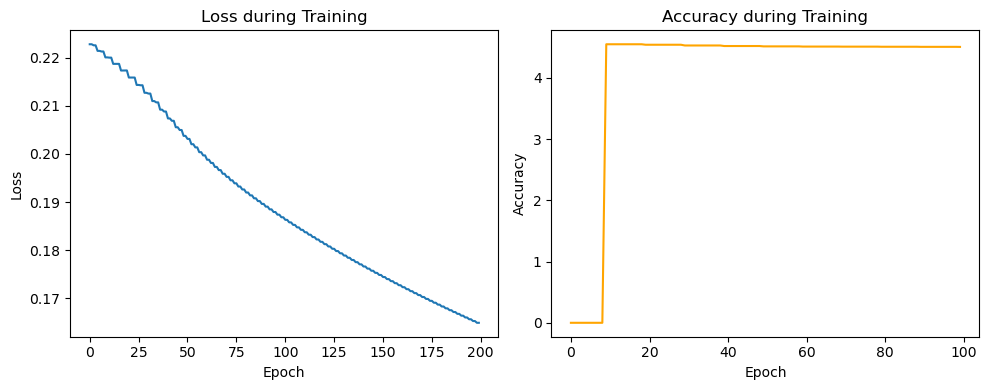

In [45]:
def plot_loss_and_accuracy(loss_values, accuracy_values):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(l)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss during Training')

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_values, color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during Training')

    plt.tight_layout()
    plt.show()

# Llamamos a la función para dibujar
plot_loss_and_accuracy(l, accuracy_values)